## Karras Pre-Conditioning 

In [1]:
import os
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>7: fc.defaults.cpus=7

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)


  0%|          | 0/2 [00:00<?, ?it/s]

Note that the scaling used here is from -1 to +1, as caused by the *2 -1

In [5]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

dl = dls.train
xb,yb = b = next(iter(dl))

In [6]:
# Note from the video.  You can get better results using 0.33, which was the value when scaling -0.5 to 5 
sig_data = 0.66

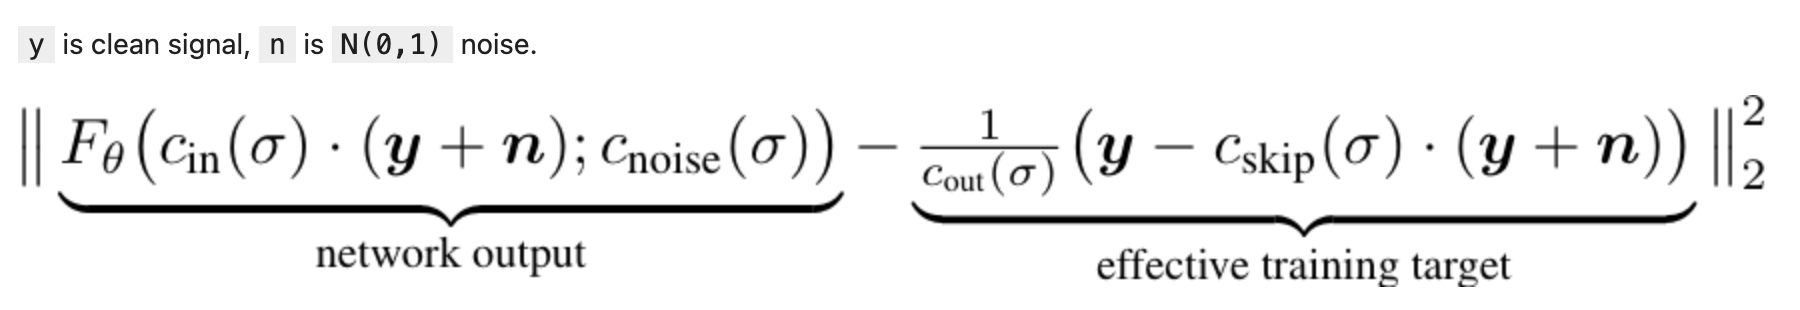

Note that Karras makes the network predict a lerp of the noise and the target image depending upon the state of the training.  Trying to predict a clean image when you already have one does not gain much, and similarly then most of the image is noise then there is not a ot of point trying to predict that.

y is the clean image and n is the noise.  Hence depending upon sskip the target will be either the image or the noise or some blend of the two.  It is important to realise that in the above formula sigma is equivalent to alphabar in the earlier work

In [13]:
def scalings(sig):
    """ Calculate c_skip, c_out, c_in as per Karras paper.  This is based upon the variance of the noise and of the image.  The two 
    variances are summed.  c_skip is dependent upon the proportion of the noise in the image over the total noise.
    c_in is the reciprical of the total variance and c_out is the product of the two standard deviations divided by the square root
    of the total variance.  c_out will be low if either of the inputs is very low
    """
    totvar = sig**2+sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2/totvar,sig*sig_data/totvar.sqrt(),1/totvar.sqrt()

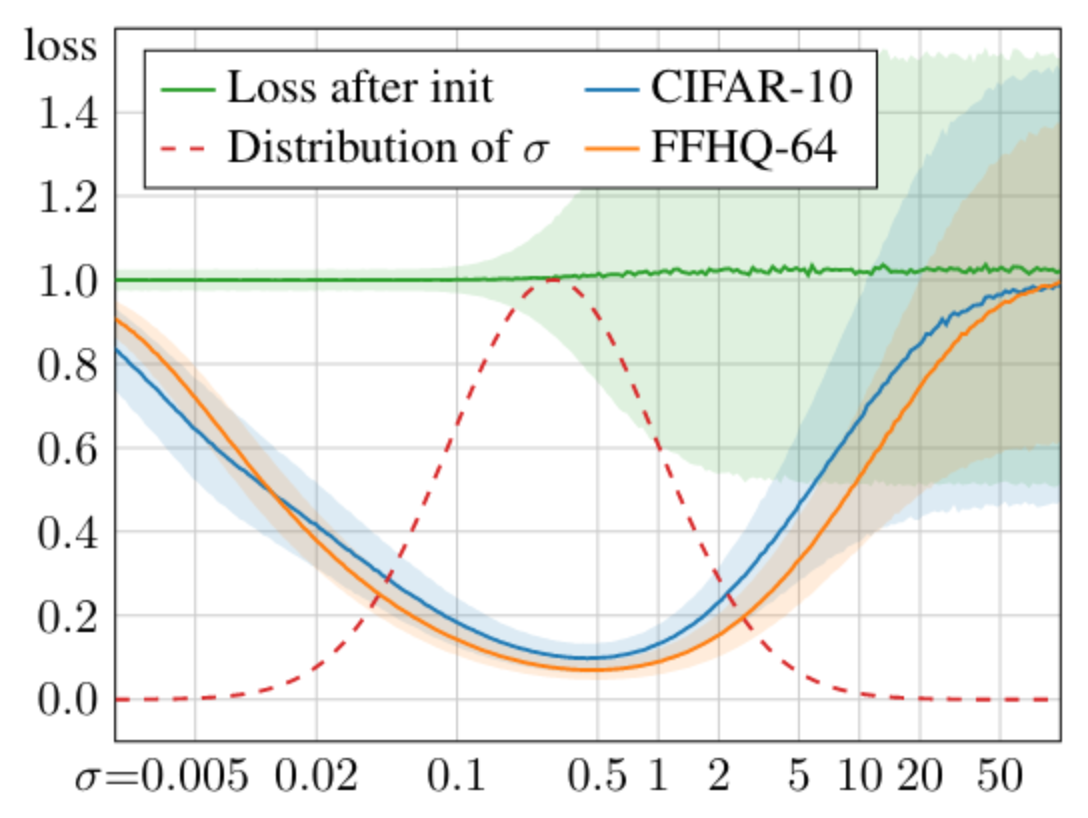

Sigma is set to be a log normal.  To sample from that the formula below can be used

In [7]:
sig_samp = (torch.randn([10000])*1.2-1.2).exp()

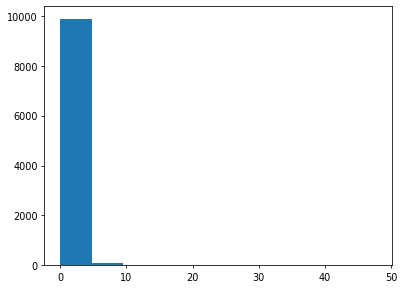

In [8]:
plt.hist(sig_samp);

In [11]:
import seaborn as sns

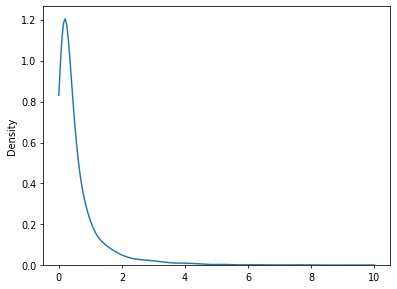

In [12]:
sns.kdeplot(sig_samp, clip=(0,10));

In [14]:
def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

In [15]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=7)

In [16]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [17]:
dl = dls.train
(noised_input,sig),target = b = next(iter(dl))

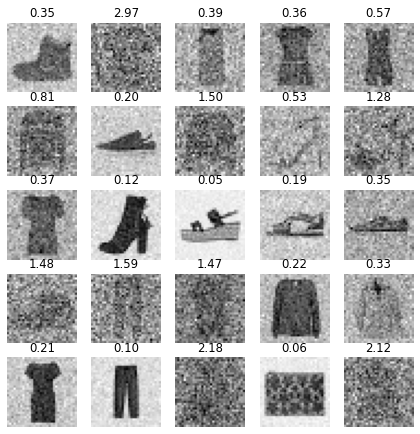

In [18]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

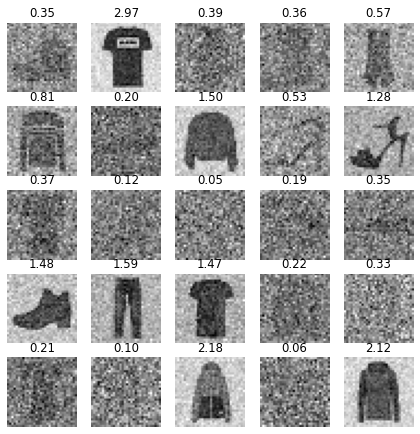

In [19]:
show_images(target[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [20]:
noised_input.mean(),noised_input.std(),target.mean(),target.std()

(tensor(-0.68649), tensor(1.01918), tensor(-0.39899), tensor(1.03314))

## Train

In [21]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [22]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()